In [12]:
!pip install redis
!pip install wordcloud
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from lib.conn_postgres import connect_to_postgres as conpg,connect_to_redis as conrds

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
conn, cur = conpg(location = 'postgres')
sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets
                  where (date_time >= NOW() - '7 day'::INTERVAL);'''

cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [14]:
r = conrds()
r.keys()

[b'hashtag_tfidf',
 b'a',
 b'tweets_tfd_svd_pipe',
 b'tweet_tfidf_fit',
 b'crackit',
 b'ktkzfnpuhr',
 b'xducctihks',
 b'jtonvogrin',
 b'tweet_tfidf_fit_transform',
 b'eaycmfglto',
 b'hashtags_tfidf_fit_transform',
 b'tweet_SVD_fit',
 b'hashtags_countvec_fit',
 b'lphhavftgd',
 b'temp_hash_count_12hr',
 b'hashtags_countvec_fit_temp',
 b'hashtags_countvec_fit_transform']

In [15]:
tfd_svd_pipe = pickle.loads(r.get('tweets_tfd_svd_pipe'))

In [16]:
TFIDF_fit =  tfd_svd_pipe.steps[0][1]
SVD_fit = tfd_svd_pipe.steps[1][1]

In [17]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [27]:
def tweets_event_ab_test(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A1['cleaned_tweet']])

    A2 = event_tweet.iloc[A_index,:] 
    #A2.reset_index(inplace = True)
    A2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)
    B1_vec_mean = np.mean(B1_vec, axis=0)
    B2_vec_mean = np.mean(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    print('Cosine Similarity')
    print('\t[A1_mean|A2_mean] : ',round(a1a2,3),'\t|\tmean of [A1_mean|A2] :',round(a2_mean,3), \
                                  '\t|\tSTD of [A1_mean|A2] :', round(a2_std,3), '\n',
          '\t[B1_mean|B2_mean] : ',round(b1b2,3), '\t|\tmean of [B1_mean|B2] :', round(b2_mean,3), \
                                   '\t|\tSTD of [B1_mean|B2] :', round(b2_std,3), '\n',
          '\t[A1_mean|B2_mean] : ', round(a2b2,3), '\t|\tmean of [A1_mean|B2] :', round(a1b2_mean,3),\
                                    '\t|\tSTD of [A1_mean|B2] :', round(a1b2_std,3)) 
    plt.figure(figsize=(18,6))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.scatter(range(len(a2_consim_list)), a2_consim_list, c = 'g', label = 'cosine similarity of A vectors')
    ax1.scatter(range(len(b2_consim_list)), b2_consim_list, c = 'r', label = 'cosine similarity of B vectors')    
    sns.distplot(a2_consim_list,color='g',ax = ax2, label = 'cosine similarity of A vectors')
    sns.distplot(b2_consim_list,color='r',ax = ax2, label = 'cosine similarity of B vectors')
    plt.legend(fontsize = 20)
    plt.show()
    
    component_1 = np.argsort(SVD_fit.explained_variance_ratio_)[::-1][0]
    component_2 = np.argsort(SVD_fit.explained_variance_ratio_)[::-1][1]
    plt.figure(figsize=(8,6))
    
   
    plt.scatter(B1_vec.T[component_1], B1_vec.T[component_2], facecolor="red", alpha=.7,marker='^', s = 100, label = 'B1 Vector')
    plt.scatter(B2_vec.T[component_1], B2_vec.T[component_2], facecolor="red", alpha=0.5,marker='x', s = 100, label = 'B2 Vector')
    plt.scatter(A2_vec.T[component_1], A2_vec.T[component_2], facecolor="green", alpha=0.5,marker='x', s = 100, label = 'A2 Vector')
    plt.scatter(A1_vec.T[component_1], A1_vec.T[component_2], facecolor="green", alpha=.7,marker='^', s = 100, label = 'A1 Vector')
    plt.legend(fontsize = 20)
    plt.show()
    #plt.xlim(-.2,1)
    #plt.ylim(-.2,1)
    
    # this is another inset axes over the main axes
    #a = plt.axes([0.5, 0.5, .45, .45], facecolor='y', alpha=.4)
    #plt.scatter(B1_vec.T[component_1], B1_vec.T[component_2], facecolor="red", alpha=.7,marker='^', s = 100)
    #plt.scatter(A1_vec.T[component_1], A1_vec.T[component_2], facecolor="green", alpha=.7,marker='^', s = 100)
    #plt.scatter(B2_vec.T[component_1], B2_vec.T[component_2], facecolor="red", alpha=0.5,marker='x', s = 100)
    #plt.scatter(A2_vec.T[component_1], A2_vec.T[component_2], facecolor="green", alpha=0.5,marker='x', s = 100)
    #plt.title('subplot')
    #plt.xlim(-.2, 0.2)
    #plt.xlim(-.2, 0.2)
    #plt.xticks([])
    #plt.yticks([])
    return a2_consim_list, b2_consim_list

In [19]:
def check_score_cluster(event,check_by_score = .7,high_score = .9):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True, drop=True)
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)

    n = int(round((event_tweet_count(event))*0.5,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())

    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True, drop=True)
    A1_vec = SVD_fit.transform(TFIDF_fit.transform(A1['cleaned_tweet']))

    A2 = event_tweet.iloc[A_index,:] 
    A2_vec = SVD_fit.transform(TFIDF_fit.transform(A2['cleaned_tweet']))
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)

    consim_twt_list = []
    for i in range(len(A1)):  
        consim_twt_list.append((cosine_similarity(A1_vec[i].reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0], A1['cleaned_tweet'][i]))
    #pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster1 = result[result['score']>high_score].sort_values('score', ascending = False)
    cluster2 = result[((result['score']<(check_by_score+.05)) & (result['score']>(check_by_score-.05)))]\
                .sort_values('score', ascending = False)
    return pd.concat([cluster1.reset_index().head(30), cluster2.reset_index().head(30)], axis=1)

In [20]:
def Top_scored_tweets_in_B(event, n = 10000):
    event = event.lower()
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop=True)
    A_vec = SVD_fit.transform(TFIDF_fit.transform(A['cleaned_tweet']))
    A_vec_mean = np.average(A_vec, axis=0)
       
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop=True)
    B1_vec = SVD_fit.transform(TFIDF_fit.transform(B1['cleaned_tweet']))
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster = result[result['score']>.7].sort_values('score', ascending = False)
    pd.set_option('display.max_colwidth', -1)
    return cluster.head(20)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


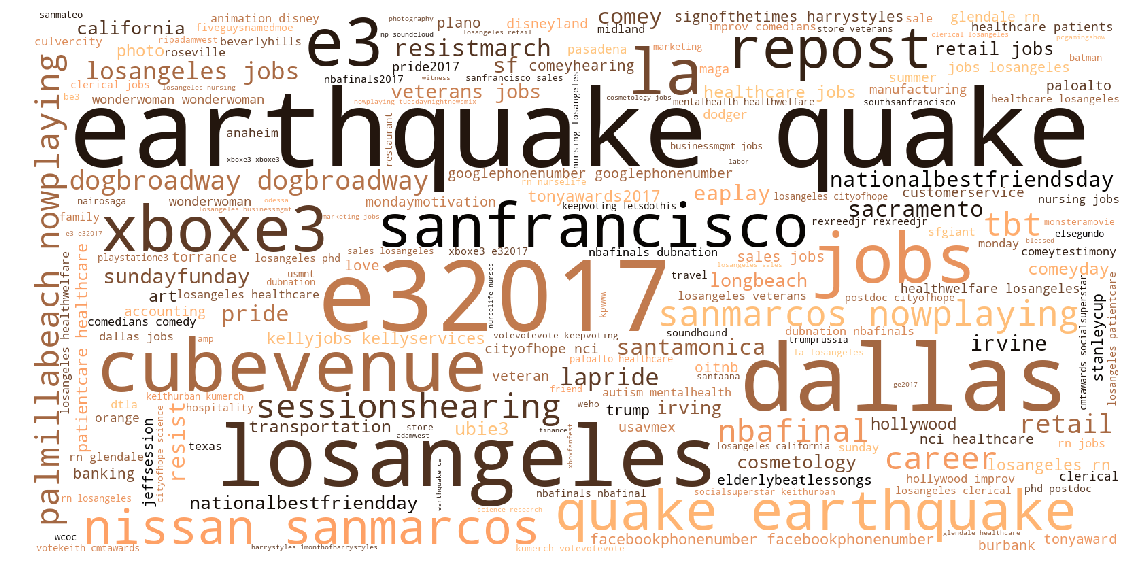

In [21]:
words = df['hashtags'][(df['hashtags'].isnull() == False) & (df['hashtags'] != 'None')]
stopwords = set(STOPWORDS)
stopwords.add("job")
stopwords.add("careerarc")
stopwords.add("hiring")
wc = WordCloud(width=1600, height=800, background_color='white', \
               relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Event Tweets (earthquake|quake):  944
Cosine Similarity
	[A1_mean|A2_mean] :  0.998 	|	mean of [A1_mean|A2] : 0.807 	|	STD of [A1_mean|A2] : 0.257 
 	[B1_mean|B2_mean] :  0.973 	|	mean of [B1_mean|B2] : 0.3 	|	STD of [B1_mean|B2] : 0.119 
 	[A1_mean|B2_mean] :  0.264 	|	mean of [A1_mean|B2] : 0.101 	|	STD of [A1_mean|B2] : 0.169


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


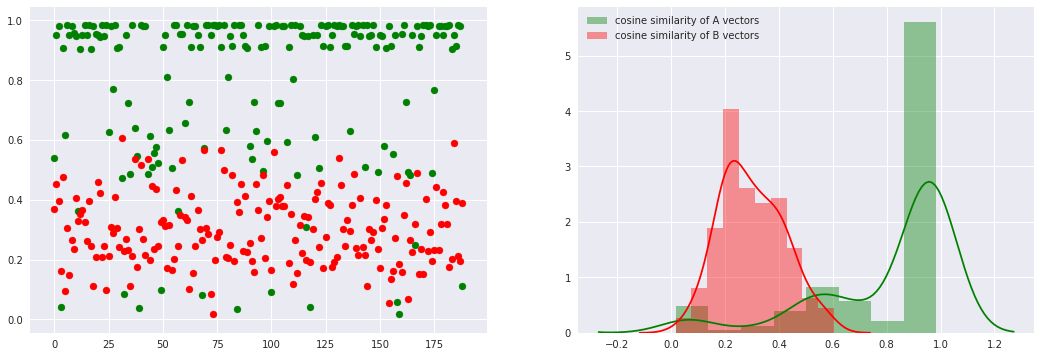

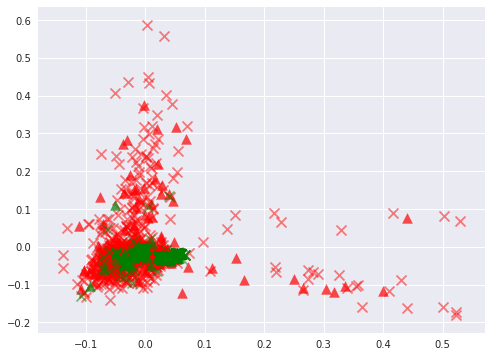

In [26]:
print('Event Tweets (earthquake|quake): ', event_tweet_count('earthquake|quake'))
A, B = tweets_event_ab_test('earthquake|quake')

In [23]:
#check high score tweets (>0.9) versus tweets with clustered scores 
check_score_cluster('earthquake|quake',.5)

,index,score,tweet,index,score,tweet
0,80,0.987288,usgs reports a m1.48 #earthquake 9km sse of ma...,421,0.538583,"california, united states ml 2.1 (243 min ago)..."
1,301,0.986663,usgs reports a m1.95 #earthquake 8km sse of bo...,66,0.537181,"california, united states ml 2.7 (323 min ago)..."
2,153,0.986663,usgs reports a m1.95 #earthquake 8km sse of bo...,404,0.534877,2.1 magnitude #earthquake. 27 km from king cit...
3,260,0.985717,usgs reports a m0.93 #earthquake 16km ne of li...,434,0.519598,1.8 magnitude #earthquake. 27 km from king cit...
4,401,0.985717,usgs reports a m0.93 #earthquake 16km ne of li...,341,0.513990,"2.1 magnitude #earthquake. 10 km from cobb, #c..."
5,392,0.985389,usgs reports a m2.8 #earthquake 3km nnw of fra...,156,0.513982,1.7 magnitude #earthquake. 11 km from dixon la...
6,391,0.985389,usgs reports a m2.8 #earthquake 3km nnw of fra...,114,0.508432,1.6 magnitude #earthquake. 15 km from mammoth ...
7,22,0.985152,usgs reports a m0.49 #earthquake 8km nne of li...,132,0.508432,1.9 magnitude #earthquake. 15 km from mammoth ...
8,10,0.984260,usgs reports a m2.34 #earthquake 8km n of lake...,291,0.506133,1.7 magnitude #earthquake. 16 km from mammoth ...
9,418,0.984230,usgs reports a m0.98 #earthquake 16km se of an...,344,0.503366,2.4 magnitude #earthquake. 24 km from kettlema...


In [24]:
Top_scored_tweets_in_B('earthquake|quake', n = 300000)

,score,tweet
178231,0.942973,1995 // city of muguets // available online 06/12 // (link on bio)
126528,0.940967,17 daysssss
277988,0.940720,. gets star on hollywood walk of fame
144295,0.939923,perks of working on hollywood blvd
100991,0.936875,summa '17
175823,0.936875,summa '17 🤷‍♀️
2777,0.936475,"greatest #vocoder on earth! #doepfer a129 signed by dieter doepfer, @ hollywood walk of fame"
56037,0.930120,"14:39 km6dqu (hugo) on w6/ct-244 (workman hill, 423m, 1pt) 14.323 ssb: switched, lots of qrm [km6dqu]"
215626,0.929610,"picture of a swan swimming on lake yamanaka near mount fuji, japan"
213844,0.928890,#sgvhopegala kickoff reception 9/16/17
